In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Check GPU
! nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-6b2f9efe-6b14-3303-aed2-9a8fadb7ffdc)


In [3]:
# Helper functions
## Creating Helper Functions
def unzip_extract(filepath : str):
  import zipfile
  #Unzip the downloaded file
  zip_ref = zipfile.ZipFile(filepath)
  zip_ref.extractall()
  zip_ref.close()

def dir_walkthrough(filename : str):
  import os
  #Walk through 10 percent data directory and see how many files/images are there in each
  for dirpath,dirnames,filenames in os.walk(filename):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

def create_tensorboard_callback(dir_name,experiment_name):
  import datetime
  log_dir = dir_name + "/" + experiment_name +"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

def plot_model_curves(history):
  import pandas as pd
  pd.DataFrame(history.history)[['loss','val_loss']].plot()
  pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()

def plot_compare_history(org_history,new_history,initial_epochs = 5):
  import matplotlib.pyplot as plt

  # Accuracy curves
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(org_history.history['accuracy']+new_history.history['accuracy'],label = "training accuracy")
  plt.plot(org_history.history['val_accuracy']+new_history.history['val_accuracy'],label = "Validation Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label = 'Fine Tuning Starts')
  plt.legend(loc = (1.1,0.5))
  plt.title("Training and Validation Accuracy")

   # Loss curves
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(org_history.history['loss']+new_history.history['loss'],label = "training loss")
  plt.plot(org_history.history['val_loss']+new_history.history['val_loss'],label = "Validation loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label = 'Fine Tuning Starts')
  plt.legend(loc = (1.1,0.5))
  plt.title("Training and Validation Accuracy")

## Use TensorFlow datasets to get Data

In [4]:
# Get Tensorflow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datets in TFDS
print("food101" in datasets_list) # Check if the needed dataset is in the list of al TFDS datasets

True


In [6]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train","validation"],
                                             as_supervised = True, # data gets returned in tuple format (data,label)
                                             with_info = True)

## Exploring the Food101 data TensorFlow Datasets

To become one with our data, we want to find:

* Class names
* The shape of our input data(image_tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor,label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# utput info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image datatype : {image.dtype}
  Target class from Food101 (tensor form) : {label}
  Class name (str form): {class_names[label.numpy()]}""")


  Image Shape : (512, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class from Food101 (tensor form) : 56
  Class name (str form): huevos_rancheros


In [11]:
# What does our image tensor look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

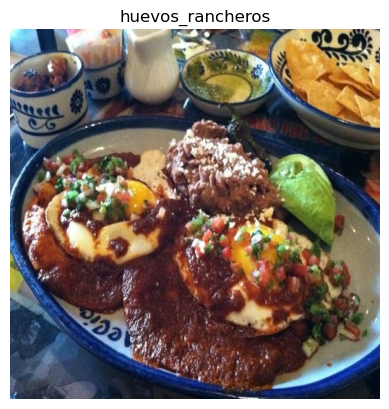

In [12]:
# What does the image look like
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [13]:
labels = []
for im,l in test_data.take(-1):
    labels.append(l)

labels = np.array(labels,np.int32)
labels[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

## Create preprocessing functions for our data

Neural network performs best when data is in a certain format (i.e. batched, normalized,etc.)

So, in order to get it ready for our neural network, we often will need to write preprocessing functions and map it to your data.

What we know abou our data:

* In `uint8` datatype
* Comprised of all different size tensors(different sized images)
* Not scaled (pixel values are between 0 and 255)

What we know models like:

* Data in `float32` dtype (or for mixed precision, `float16` and `float32`)
* For batches, Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 and 1), also called normalized tensors

In [14]:
# Make a function to preprocess images
def preprocess_image(image,label,img_shape = 224):
  """
  Converts image datatype from `uint8` to `float32` and reshapes image to [img_shape,img_shape,colour_channels]
  """

  image = tf.image.resize(image,[img_shape,img_shape]) # Reshape
  # image = image/255. # scale image values (required for models like ResNet)
  return tf.cast(image,tf.float32),label # return (float32_image,label) tuple

In [15]:
# Preprocess a simgle sample image and check the outputs
preprocessed_img = preprocess_image(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batch and Prepare datasets

In [16]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func = preprocess_image,num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test_data
test_data = test_data.map(preprocess_image,num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

We will create a couple of callbacks to help us while our model trains:
* ModelCheckpoint callback to save our model's progress after feature extraction

* ReduceLROnPlateau to help the model learn more effectively by decreasing learning rate when model stops improving.


In [18]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                               monitor = 'val_loss',
                                                               save_best_only = True,
                                                               save_weights_only = True,
                                                               verbose = 1)

# Create LRScheduler callback
def scheduler(epoch,lr):
    if epoch % 2 ==0:
        return lr*0.1
    else:
        return lr

LRS_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Setup mixed precision training

For a deeper understanding on mixed precision training, check out the TensorFlow guide for mixed precision:
https://www.tensorflow.org/guide/mixed_precision

In [19]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Build Feature extraction model

In [21]:
# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B3(include_top = False,pooling = 'avg')
base_model.trainable = False

# Create functional model
inputs = tf.keras.layers.Input(shape = input_shape,name = "input_layer")
x = tf.keras.layers.Rescaling(1./255)(inputs) # For models like ResNet
x = base_model(inputs,training = False)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax",dtype = tf.float32,name = "softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ["accuracy"])


In [22]:
hist = model.fit(train_data,epochs = 5,
                 steps_per_epoch = len(train_data),
                 batch_size = 32,
                 validation_data = test_data,
                 validation_steps = int(0.2*len(test_data)),
                 callbacks = [model_checkpoint_callback,LRS_callback])

Epoch 1/5
   1/2368 [..............................] - ETA: 19:14:54 - loss: 4.7268 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [23]:
model.load_weights(checkpoint_path)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model_checkpoints/cp.ckpt

In [24]:
model.evaluate(test_data)

  1/790 [..............................] - ETA: 2:03:49 - loss: 4.5992 - accuracy: 0.0312

KeyboardInterrupt: 

In [ ]:
preds_final = model.predict(test_data).argmax(axis = 1)
preds_final

In [ ]:
len(preds_final)

25250